In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st
from tqdm import tqdm

In [83]:

def euler_Method(S0, interest_rate, delta_t, N, volatality):
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = norm.rvs()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [84]:
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)


In [85]:
def mean_confidence_interval(data):
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m, m - h, m + h

In [86]:
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type):
    
    pay_offs = np.zeros(M)
    
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        
        pay_offs[i] = pay_off
    
    _, ml, mu = mean_confidence_interval(pay_offs * np.exp(-r*T))
    
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [87]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
    
    return option_price

In [88]:
m = []
option_values = []
std_errors = []
lower = []
upper = []
for M in tqdm(np.arange(100, 10000, 100)):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    m.append(M)
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)

100%|██████████| 99/99 [29:04<00:00, 17.62s/it]   


In [89]:
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
option_BS = blackScholes(S0, K, 0, T, r, sigma)

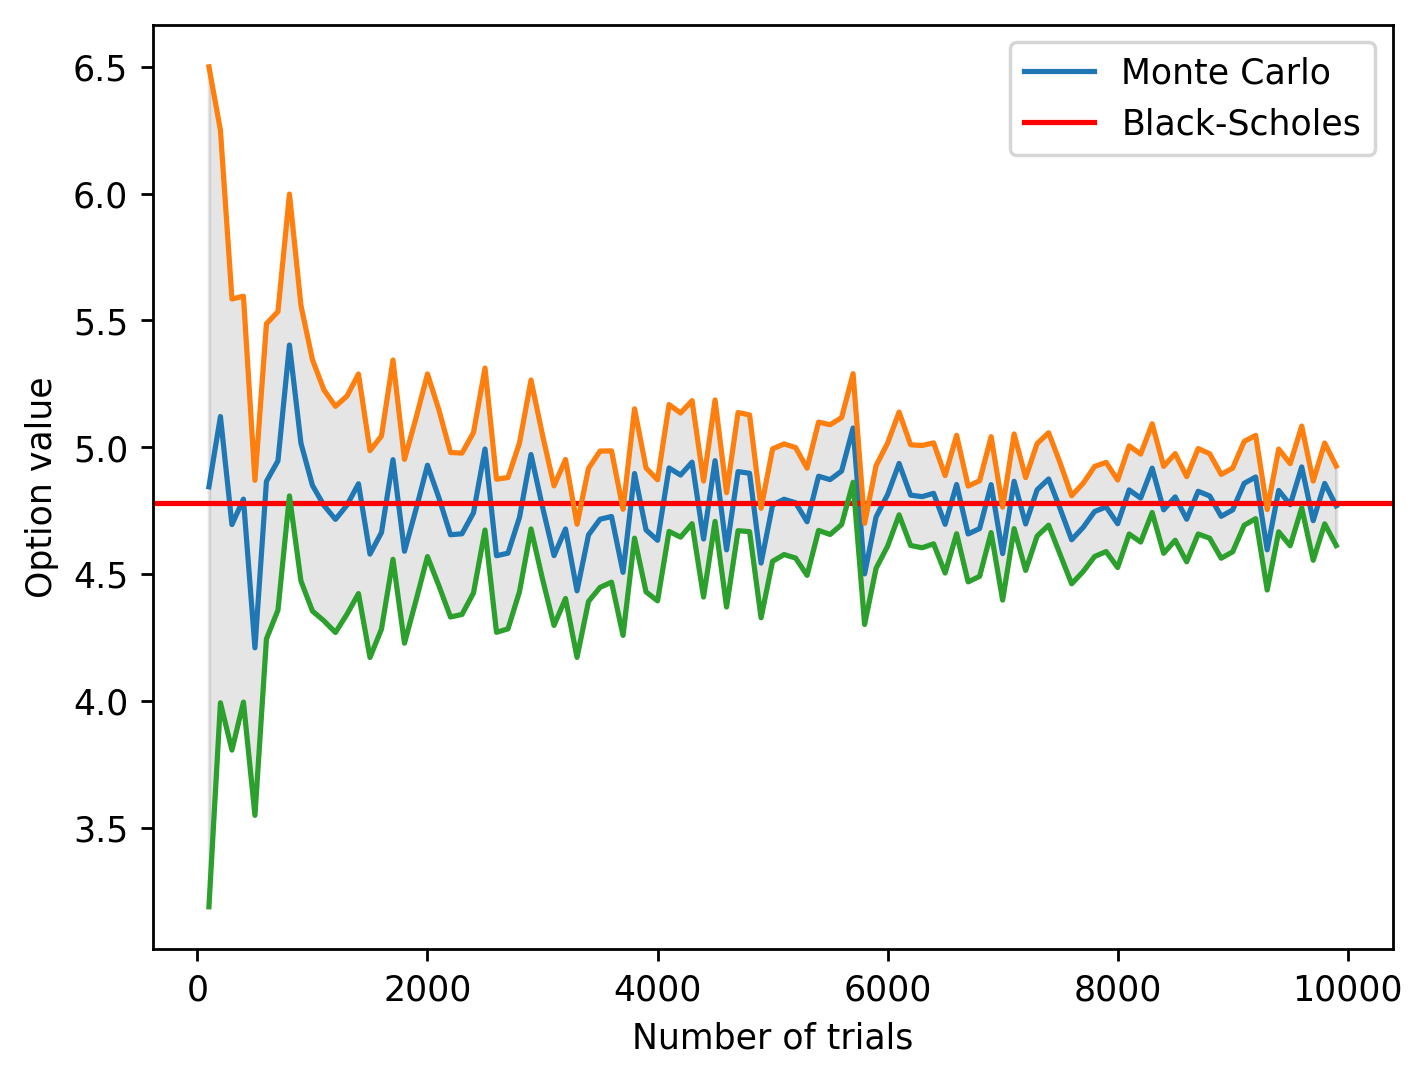

In [90]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, color = "red", label="Black-Scholes")
plt.plot(m, upper)
plt.plot(m, lower)
plt.fill_between(m, upper, lower, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

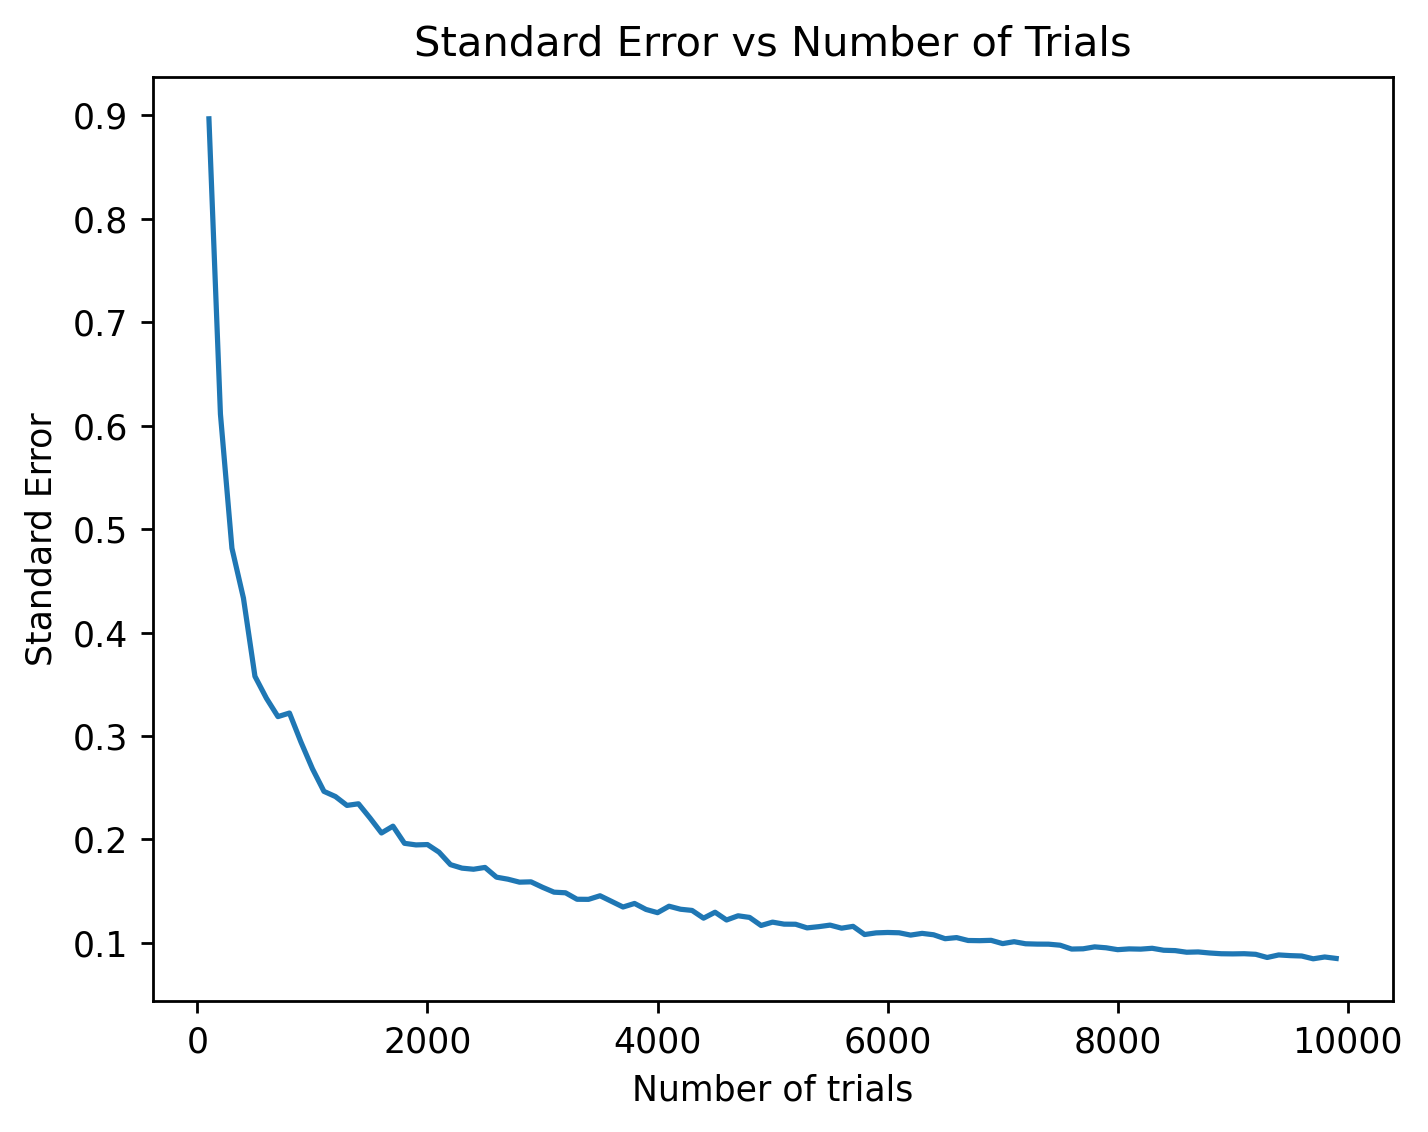

In [91]:
plt.figure(dpi=250)
plt.plot(m, std_errors)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Number of Trials")
plt.show()

In [92]:
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.5
delta_t = 1/252
N = int(T/delta_t)
option_values2= []
std_errors2 = []
lower2 = []
upper2 = []
for M in tqdm(np.arange(100, 10000, 100)):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    m.append(M)
    option_values2.append(option_value)
    std_errors2.append(sd_error)
    lower2.append(ml)
    upper2.append(mu)

100%|██████████| 99/99 [17:09<00:00, 10.40s/it]


In [93]:
option_BS2 = blackScholes(S0, K, 0, T, r, sigma)

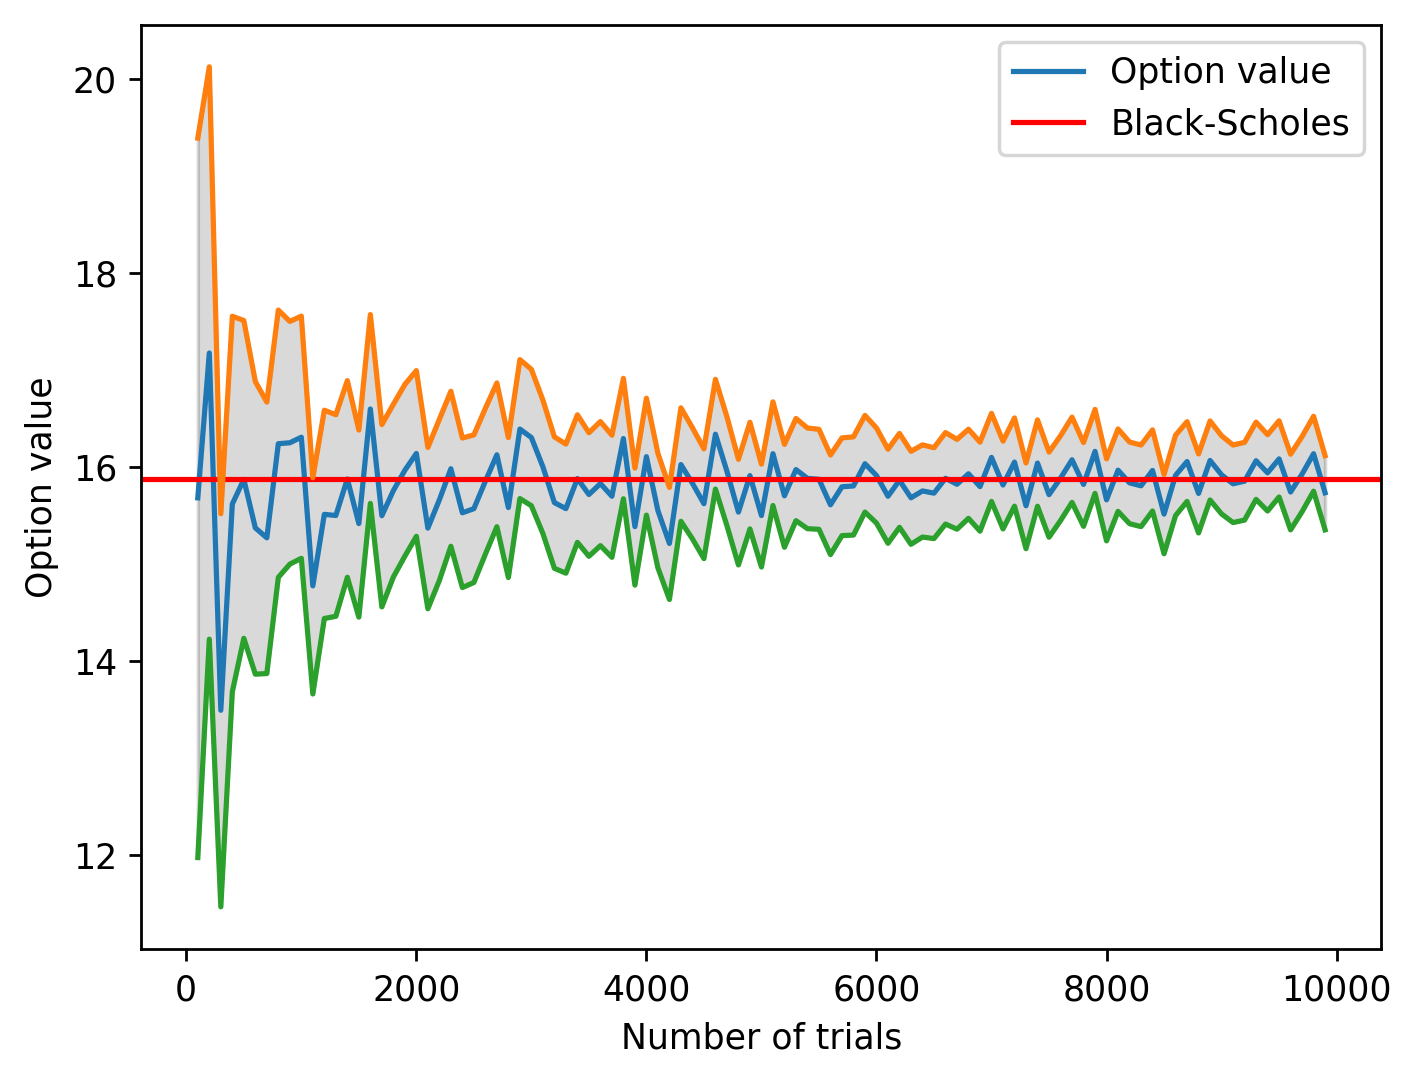

In [96]:
m = np.arange(100, 10000, 100)
plt.figure(dpi=250)
plt.plot(m, option_values2, label='Option value')
plt.axhline(option_BS2, color = "red", label="Black-Scholes")
plt.plot(m, upper2)
plt.plot(m, lower2)
plt.fill_between(m, upper2, lower2, color="k", alpha=0.15)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

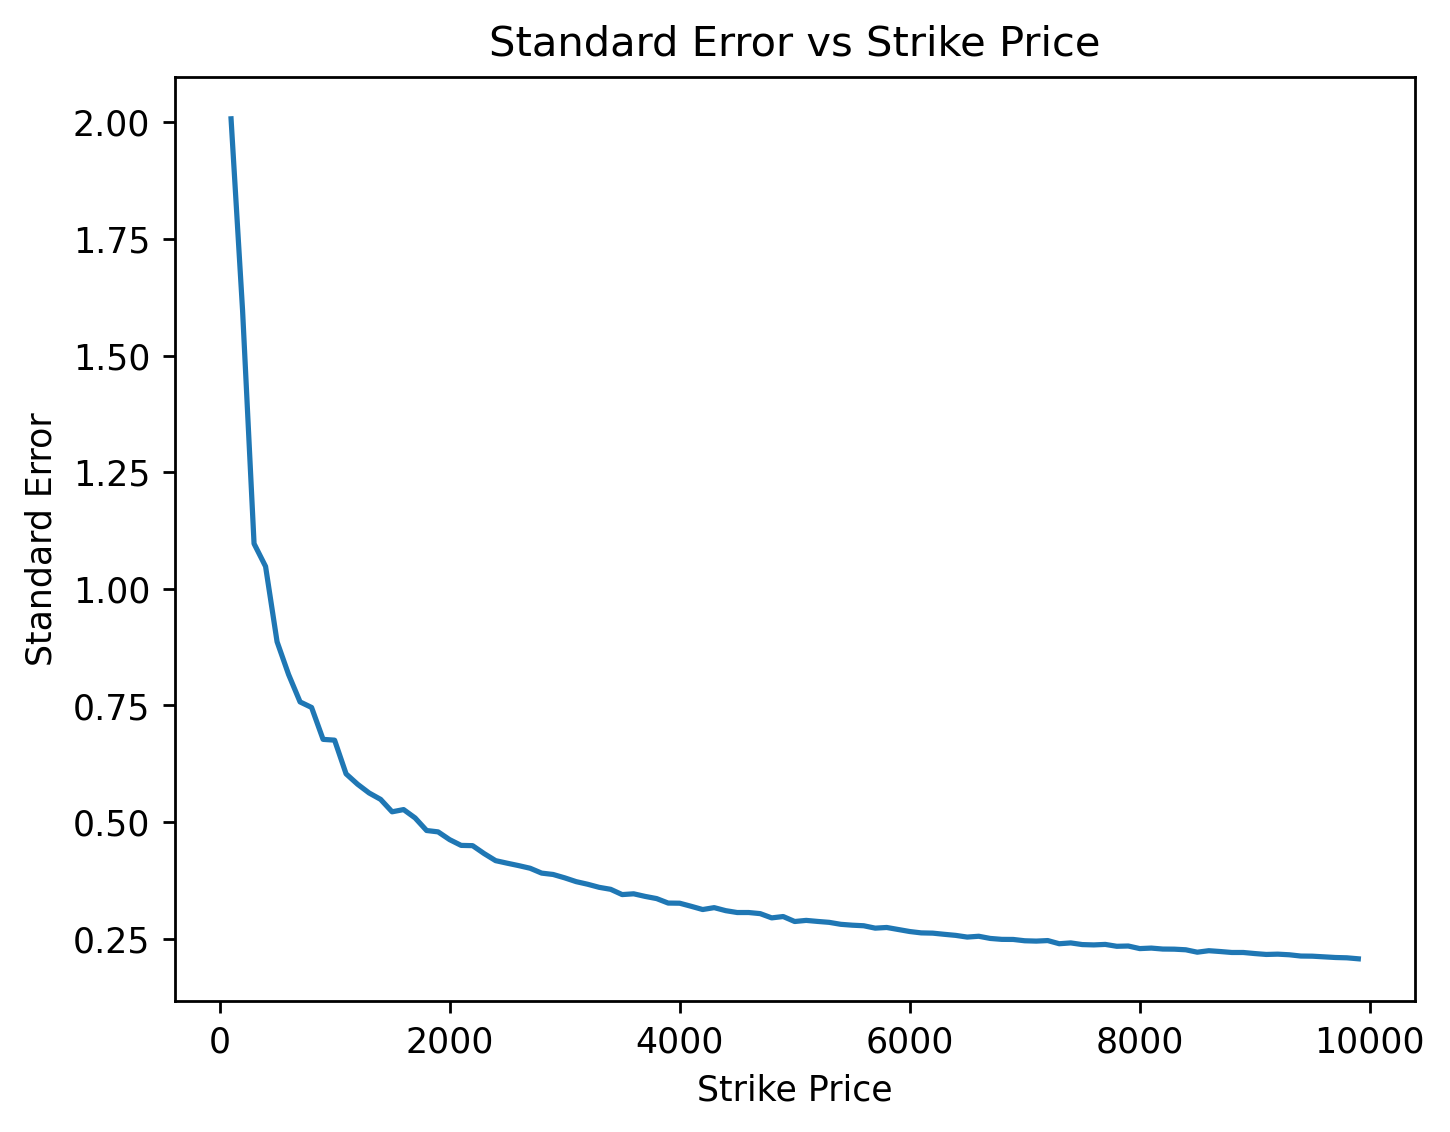

In [97]:
plt.figure(dpi=250)
plt.plot(m, std_errors2)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Strike Price")
plt.show()

In [68]:
## Varying strike price
K = np.arange(80, 120, 2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)
option_values3 = []
std_errors3 = []
lower3 = []
upper3 = []

for k in tqdm(K):
    option_value, sd_error , ml, mu  = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    option_values3.append(option_value)
    std_errors3.append(sd_error)
    lower3.append(ml)
    upper3.append(mu)

100%|██████████| 20/20 [13:03<00:00, 39.19s/it]


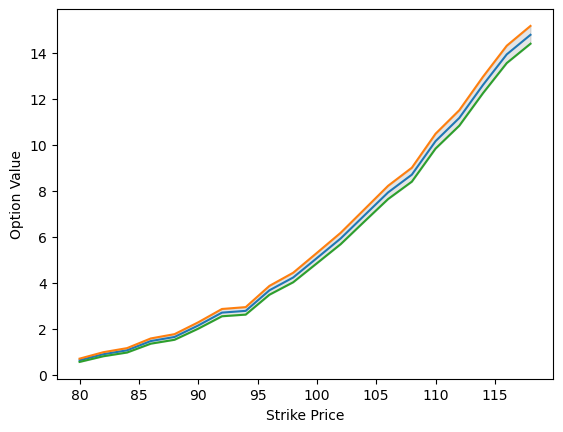

In [71]:
##Plotting the option values
plt.plot(K, option_values3)
plt.plot(K, upper3)
plt.plot(K, lower3)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.fill_between(K, upper3, lower3, color="k", alpha=0.1)

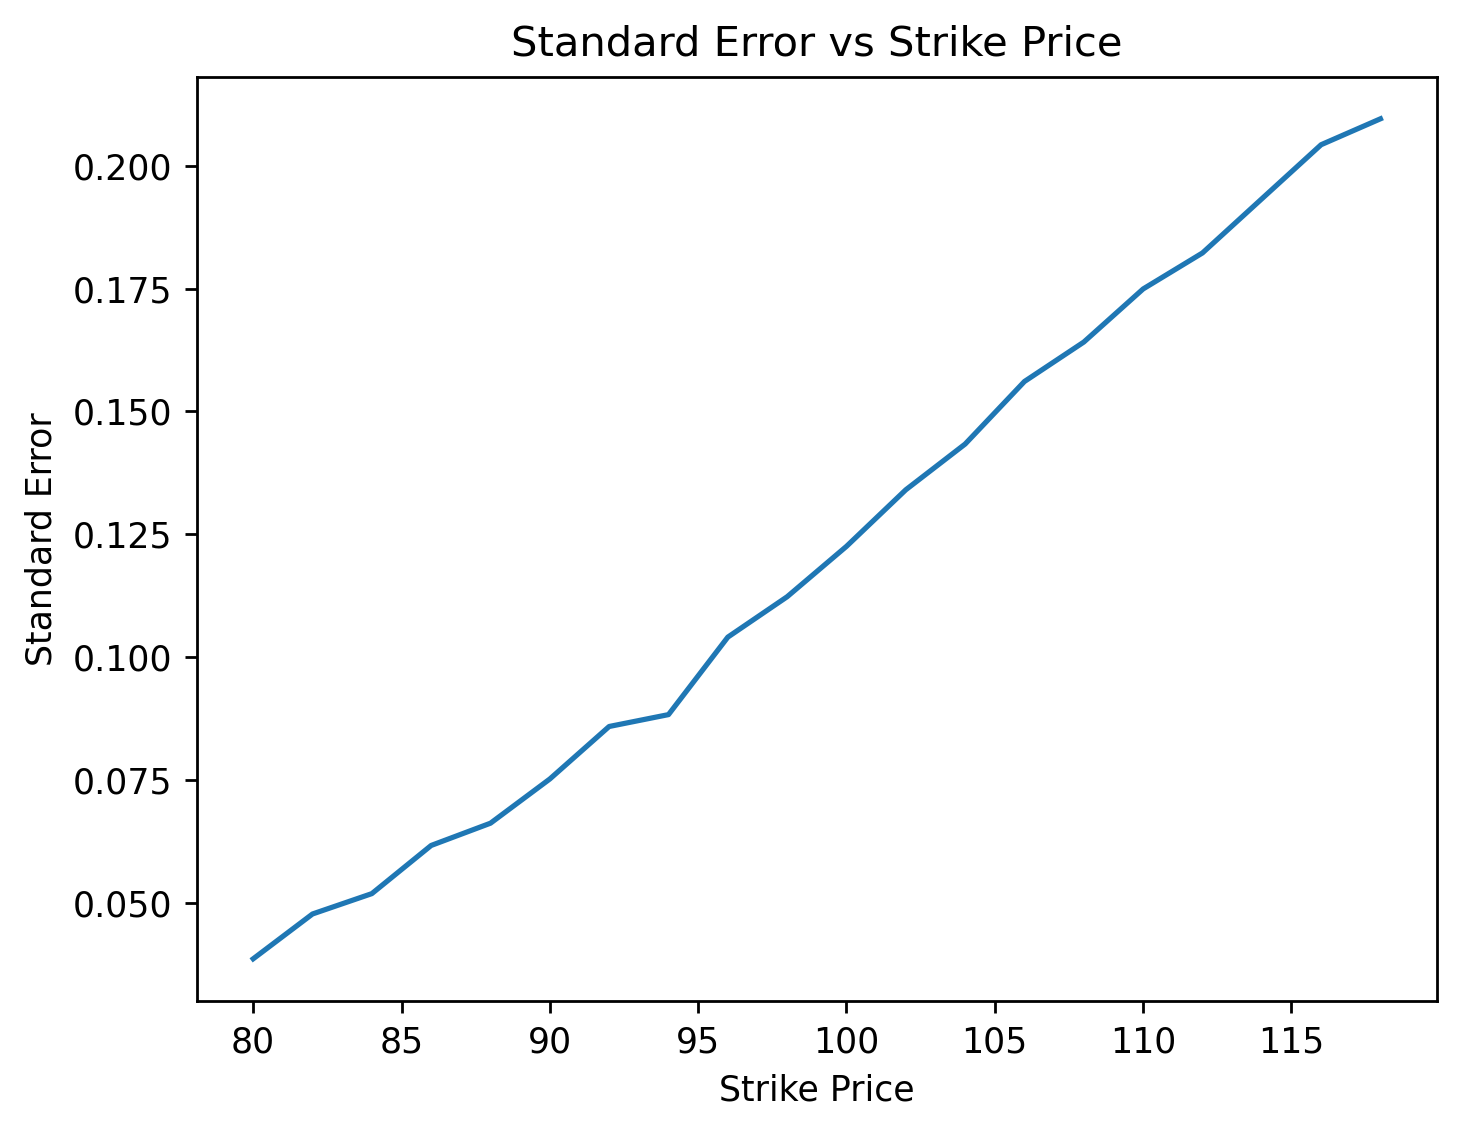

In [81]:
plt.figure(dpi=250)
plt.plot(K, std_errors3)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Strike Price")
plt.show()

In [ ]:
### Varying volatality
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)
option_values = []
for vol in vols:
    option_value = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    m.append(M)
    option_values.append(option_value)

In [ ]:
##Plotting the option values
plt.plot(vols, option_values)
plt.xlabel("Volatality")
plt.ylabel("Option Value")

### Part I - B

##### Milstein Variance Process

In [98]:
## Milstein Variance Process
def m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, Barrirer):
    prev_v = 0
    prev_S = S0
    Zv = np.random.normal()
    Z2 = np.random.normal()
    Zs = corr * Zv + (1 - corr**2) * Z2
    #variance = [prev_v]
    #assetPrice = [prev_S]
    
    for _ in np.arange(dt, 1., dt):
        vplus = max(0, prev_v)
        next_v = prev_v + k * (theta - vplus) * dt + vol_of_vol * np.sqrt(vplus * dt) * Zv + vol_of_vol ** 2 * dt * (Zv**2-1)/4
        next_S = prev_S + r * prev_S * dt + np.sqrt(vplus * dt) * Zs * prev_S + vplus * prev_S* dt * (Zs ** 2 - 1)/2
        prev_v = next_v
        
        if next_S >= Barrirer:
            print("Barrier breached",next_S )
            return 0
        #variance.append(prev_v)
        #assetPrice.append(next_S)
    option_value = max(0, next_S - 100)
    
    return option_value
        

In [99]:
#### Initial Parameters
r = 0.05
theta = 0.04
k = 2
vol_of_vol = 0.1
corr = - 0.7
dt = 1/252
S0 =100
T = 1.0

In [100]:
option_prices = []
for _ in range(10000):
    option_value = m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, 120)
    option_prices.append(option_value)
option_approx = np.mean(option_prices) * np.exp(-r* T)

In [101]:
option_approx

0.1700953018169716